In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
#import keras
import pandas as pd
#from keras_tqdm import TQDMNotebookCallback


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.compat.v1.python_io.tf_record_iterator(tfrecord))
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    laugh_labels = [66, 67] # changed to labels for cheer and applause
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

### 3 Layer LSTM

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM, TimeDistributed
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

lstm3_model = Sequential()
lstm3_model.add(BatchNormalization(input_shape=(None, 128)))
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, #activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))

lstm3_model.add(Dense(1, activation='softmax'))

lstm3_model.summary()

# try using different optimizers and different optimizer configs
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
lstm3_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v2 (Batc (None, None, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, None, 64)          49408     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, None, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, None, 64)          2

In [4]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 12657 # find # of records in 'bal_laugh_speech_subset.tfrecord'
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
lstm3_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=1)

W0326 18:40:42.894921 140526481299200 deprecation.py:323] From <ipython-input-2-b9f9d5b41141>:12: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Epoch 1/100
355/355 [==============================] - 12s 34ms/step - loss: 4.6915 - accuracy: 0.7872 - val_loss: 4.1689 - val_accuracy: 0.9106
Epoch 2/100
355/355 [==============================] - 7s 21ms/step - loss: 4.1641 - accuracy: 0.8757 - val_loss: 3.9277 - val_accuracy: 0.9306
Epoch 3/100
355/355 [==============================] - 7s 21ms/step - loss: 3.9387 - accuracy: 0.8885 - val_loss: 3.7726 - val_accuracy: 0.9280
Epoch 4/100
355/355 [==============================] - 7s 21ms/step - loss: 3.7934 - accuracy: 0.8940 - val_loss: 3.6619 - val_accuracy: 0.9262
Epoch 5/100
355/355 [==============================] - 7s 21ms/step - loss: 3.6903 - accuracy: 0.8996 - val_loss: 3.5620 - val_accuracy: 0.9349
Epoch 6/100
355/355 [==============================] - 7s 21ms/step - loss: 3.6097 - accuracy: 0.9006 - val_loss: 3.5090 - val_accuracy: 0.9323
Epoch 7/100
355/355 [==============================] - 7s 21ms/step - loss: 3.5403 - accuracy: 0.9055 - val_loss: 3.4592 - val_accuracy

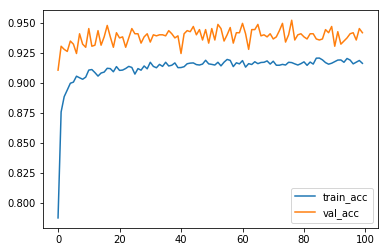

In [5]:
plt.plot(lstm3_model.history.history['accuracy'], label='train_acc')
plt.plot(lstm3_model.history.history['val_accuracy'], label='val_acc')
plt.legend()

In [6]:
lstm3_model.save('../Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

In [14]:
keras.__version__

'2.0.6'

In [33]:
from tensorflow.keras.callbacks import History

In [34]:
lstm3_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])